## XÁC ĐỊNH HIỆU XE GẮN MÁY TỪ ẢNH

MSSV-22520380

Họ và Tên: Hồ Ngọc Hải

- Import thư viện và module để chuẩn bị dữ liệu, xử lý hình ảnh và xây dựng model. Trong đó, có các lớp layer từ keras để xây dựng model.
- https://www.tensorflow.org/guide/keras/sequential_model

In [536]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

- Tiếp đến là chuẩn bị dữ liệu, trong đó duyệt các thư mục chứa ảnh để xử lý ảnh bằng cách chuyển sang numpy và cũng có thể giúp tương thích với các thư viện, trực quan hóa. Đồng thời chia tập huấn luyện và kiểm tra.

In [537]:
# Định nghĩa đường dẫn tới thư mục dữ liệu
data = 'data/'

# Khởi tạo các danh sách lưu trữ hình ảnh và nhãn
images = []
labels = []

# Định nghĩa các nhãn và thư mục tương ứng
classes = ['Honda', 'Yamaha', 'Suzuki', 'VinFast']
label_to_index = {label: idx for idx, label in enumerate(classes)}

# Duyệt qua các thư mục và tải ảnh
for class_name in classes:
    class_dir = os.path.join(data, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path, target_size=(300, 300))
        img = img_to_array(img)
        images.append(img)
        labels.append(label_to_index[class_name])

# Chuyển đổi danh sách thành mảng numpy
images = np.array(images)
labels = np.array(labels)

# Chia tập dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

## Dataset Visualization

- Hiển thị những hình ảnh từ các tệp được cung cấp bằng cách sử dụng hàm có một mạng lưới, mỗi hàng là một loại xe gắn máy được lấy từ data.

d:\Python\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


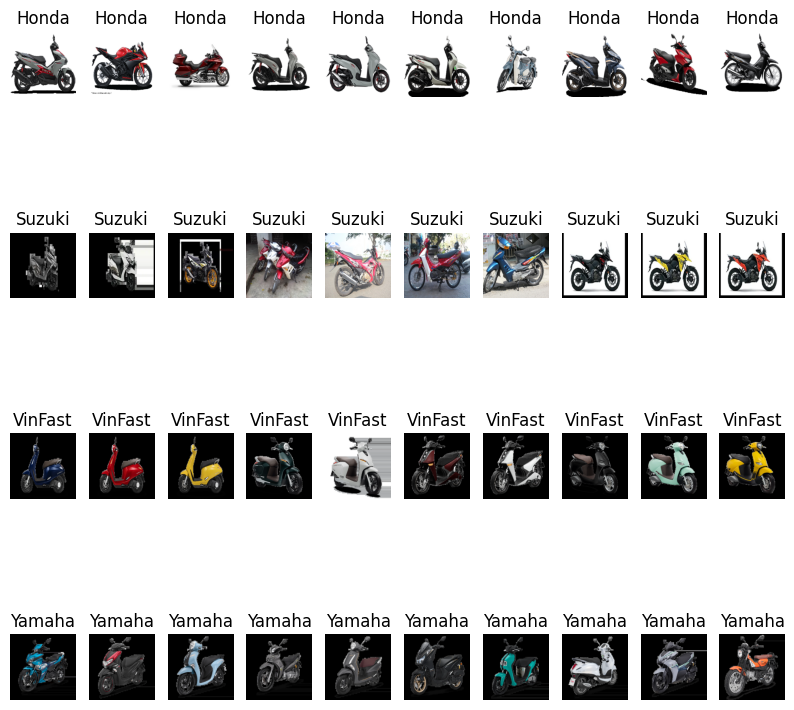

In [538]:
def visualize_data(data):
    categories = os.listdir(data)
    plt.figure(figsize=(10, 10))
    img_count = 0 # Biến đếm số lượng ảnh 
    num_img = 10 # Số lượng ảnh của mỗi loại
    
    for i, category in enumerate(categories):
        category_dir = os.path.join(data, category)
        image_paths = os.listdir(category_dir)[:num_img]
        
        for j, image_path in enumerate(image_paths):
            img_count = i * num_img + j + 1
            img = load_img(os.path.join(category_dir, image_path), target_size=(300, 300))
            plt.subplot(len(categories), num_img, img_count)
            plt.imshow(img)
            plt.title(category)
            plt.axis('off')
    
    plt.show()

data = 'data/'
visualize_data(data)

## Data Augmentation

- Trước tiên chuyển đổi labels thành dạng one-hot encoding vì nhiều mô hình cần đầu ra ở dạng này, đặc biệt là khi có nhiều classes khác nhau.
- Tiếp đến là khởi tạo ImageDataGenerator để tạo ra dữ liệu thay thế từ dữ liệu gốc. Điều này giúp tăng cường dữ liệu huấn luyện bằng cách áp dụng các biến đổi ngẫu nhiên như xoay, dịch chuyển, cắt cúp, phóng to, lật ngang, để mô hình học được đa dạng hơn và tránh overfitting.
- Sau đó tạo generator cho tập huấn luyện và tập kiểm tra để giúp mô hình deep learning huấn luyện theo từng batch dữ liệu, giúp tiết kiệm bộ nhớ và tăng tốc quá trình huấn luyện.

In [539]:
y_train = to_categorical(y_train, num_classes=len(classes))
y_val = to_categorical(y_val, num_classes=len(classes))
# Khởi tạo ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

# Tạo generator cho tập huấn luyện và tập kiểm tra
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Kiểm tra nhãn
print(label_to_index)

{'Honda': 0, 'Yamaha': 1, 'Suzuki': 2, 'VinFast': 3}


## Model Training

- Như đã nói ở trên thì sẽ sử dụng model Sequential nhưng trước tiên, ta cần phải đặt num_classes là số hãng xe để phục vụ training model như bên dưới.
- Lớp `Conv2D` giúp mô hình học được các features từ dữ liệu hình ảnh, trích xuất đặc trưng.
- Lớp `MaxPooling2D` giúp giảm chi phí tính toán.
- `Flatten` để chuyển đổi đầu vào từ ma trận 2D thành vecto 1D nhằm chuẩn bị cho các lớp `Dense` sau.
- Tiếp đến, cấu hình mô hình với optimizer là `adam` để tối ưu hóa, loss function là `categorical_crossentropy` phù hợp cho bài toán phân loại nhiều lớp, và metrics là `accuracy` để đánh giá hiệu suất mô hình.
- Cuối cùng là huấn luyện mô hình, đặc biệt số lần học của máy được tăng lên 40 lần.
- Ban đầu có sử dụng LogisticRegression nhưng vì sự chênh lệch số features của X và img_array cũng như accurcy quá thấp khiến việc dự đoán sai.

In [540]:
# Khởi tạo mô hình Sequential
num_classes = len(classes)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5), # Ngẫu nhiên loại bỏ 50% các đơn vị trong quá trình training, giảm overfitting
    Dense(num_classes, activation='softmax') #Số lượng đơn vị bằng số lớp/hãng xe
])

# Compile mô hình
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    epochs=40
)

d:\Python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/40


d:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3125 - loss: 1.4003 - val_accuracy: 0.2500 - val_loss: 7.4096
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2500 - val_loss: 7.4096
Epoch 3/40


d:\Python\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2500 - loss: 6.4564 - val_accuracy: 0.2500 - val_loss: 7.7558
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2500 - val_loss: 7.7558
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2500 - loss: 7.6885 - val_accuracy: 0.3750 - val_loss: 2.9666
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3750 - val_loss: 2.9666
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3125 - loss: 3.2152 - val_accuracy: 0.2500 - val_loss: 1.8141
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2500 - val_loss: 1.8141
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3750 - loss: 1.7137 - val_accuracy: 0.2500 - val_loss: 1.3078
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2500 - val

## MODEL EVALUATION

- Đánh giá model cho ta biết độ chính xác của model đó trên tập kiểm tra và giá trị hàm mất của nó.

In [541]:
# Đánh giá mô hình
loss, accuracy = model.evaluate(validation_generator)
print(f'Test accuracy: {accuracy:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7500 - loss: 0.6344
Test accuracy: 0.75


- Hàm sau đây làm nhiệm vụ tiền xử lý dữ liệu hình ảnh bao gồm:
  + Resize ảnh về kích thước phù hợp với đầu vào của mô hình.
  + Chuyển ảnh sang mảng numpy.
  + Mở rộng chiều của mảng numpy vì model yêu cầu input là một batch.
  + Chuẩn hóa giá trị các pixel để cải thiện việc train model và tốc độ.

In [542]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(300, 300))  # Thay đổi kích thước ảnh sao cho phù hợp với số features có trong model
    img_array = img_to_array(img)  # Chuyển ảnh thành mảng numpy
    img_array = np.expand_dims(img_array, axis=0)  # Chuyển đổi thành mảng 4 chiều
    img_array /= 255.0  # Chuẩn hóa giá trị pixel
    return img_array

- Hàm sau đây để dự đoán label của một hình mà ta cho bất kỳ và hiển thị ảnh lên cùng với label đó.
- Đặc biệt trong hàm có code thực hiện việc lấy một phần tên file ảnh đó làm loại xe (dựa vào cách đặt tên ngăn cách bởi dấu `.` cùng với đường dẫn đến file ảnh ngăn cách bởi dấu `/`).
- Tiếp đến là dự đoán label bằng cách sử dụng model.
- Cuối cùng là hiển thị ảnh và nhãn dự đoán.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


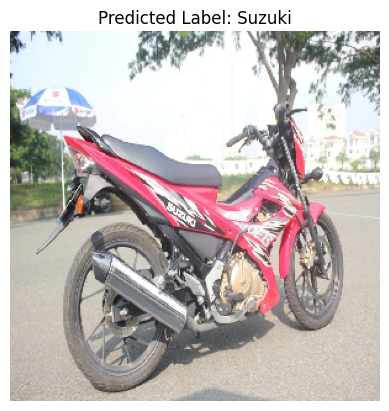

This type of motocycle is: Suzuki_Raider


In [543]:
def predict_and_show_image(model, image_path):
    img_array = preprocess_image(image_path)
    
    # Dùng tên của file ảnh làm phần dự đoán loại xe
    filename = image_path.split('/')[-1]
    label = filename.split('.')[1]

    # Dự đoán nhãn
    predictions = model.predict(img_array)
    labels = ['Honda', 'Yamaha', 'Suzuki', 'VinFast']
    predicted_label = labels[np.argmax(predictions)]
    
    img = load_img(image_path, target_size=(300, 300))  # Load lại hình ảnh để hiển thị
    
    # Hiển thị hình ảnh và nhãn dự đoán
    plt.imshow(img)
    plt.title(f'Predicted Label: {predicted_label}')
    plt.axis('off')
    plt.show()

    return label

image_path = 'data/Suzuki/22520380.Suzuki_Raider.4.png'
prediction = predict_and_show_image(model, image_path)
print(f'This type of motocycle is: {prediction}')